In [35]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

(-0.5, 1919.5, 959.5, -0.5)

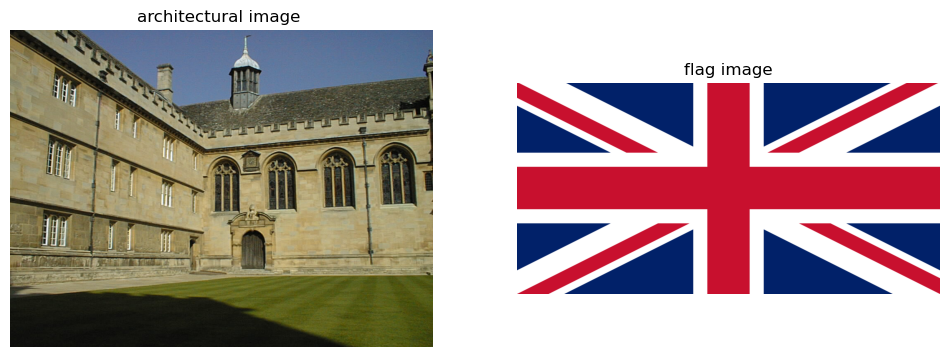

In [36]:
# Load images
architectural_image = cv.imread("../../images/005.jpg")  
flag_image = cv.imread("../../images/flag.png", cv.IMREAD_UNCHANGED) 
# Create an alpha channel (fully opaque)
alpha_channel = np.ones((flag_image.shape[0], flag_image.shape[1]), dtype=flag_image.dtype) * 255  # Fully opaque

# Combine the RGB channels with the alpha channel
flag_image_with_alpha = cv.merge((flag_image, alpha_channel))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(architectural_image, cv.COLOR_BGR2RGB))
plt.title('architectural image ')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(flag_image_with_alpha, cv.COLOR_BGR2RGB))
plt.title('flag image')
plt.axis('off')

In [37]:
# Function to select points on the image
def select_points(event, x, y, flags, param):
    global points, img_copy
    if event == cv.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv.circle(img_copy, (x, y), 5, (0, 255, 0), -1)
        cv.imshow("Image", img_copy)


In [45]:
# Prepare variables for point selection
points = []
img_copy = architectural_image.copy()

# Show the architectural image and set up point selection
cv.imshow("Image", img_copy)
cv.setMouseCallback("Image", select_points)
cv.waitKey(0)
cv.destroyAllWindows()

# Ensure we have four points
if len(points) != 4:
    raise ValueError("You must select exactly four points.")

In [47]:
print(points)

[(200, 536), (467, 545), (465, 303), (222, 154)]


In [48]:
flag_image_with_alpha.shape

(960, 1920, 4)

In [50]:
# Define the corresponding points in the flag image
flag_height, flag_width = flag_image_with_alpha.shape[:2]
flag_corners = np.array([[0, 0], [flag_width, 0], [flag_width, flag_height], [0, flag_height]], dtype="float32")
print(flag_height, flag_width, flag_corners)

# Compute the homography
points = np.array(points, dtype="float32")
print(points)

homography_matrix, _ = cv.findHomography(flag_corners, points)
print(homography_matrix)

# Warp the flag image to the architectural image
warped_flag = cv.warpPerspective(flag_image_with_alpha, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))

# Check if the warped flag has an alpha channel
if warped_flag.shape[2] == 4:  # If there is an alpha channel
    flag_mask = (warped_flag[..., 3] > 0).astype(np.uint8)  # Get the alpha channel for masking
    warped_flag_rgb = warped_flag[..., :3]  # Get the RGB channels of the warped flag
    print('alpha')
else:
    flag_mask = np.ones_like(warped_flag[..., 0], dtype=np.uint8)  # Create a mask of ones (fully opaque)
    warped_flag_rgb = warped_flag  # Use the RGB channels directly
    print('no alpha')

# Define the transparency factor (0 to 1)
transparency_factor = 0.5  # Example: 50% transparent

# Adjust the flag mask based on the transparency factor
adjusted_flag_mask = flag_mask * transparency_factor  # Scale the mask

# Ensure the adjusted mask is in the correct range [0, 1]
adjusted_flag_mask = np.clip(adjusted_flag_mask, 0, 1)

# Blend the images with the adjusted transparency
blended_image = architectural_image.copy()
for c in range(0, 3):
    blended_image[..., c] = (
        blended_image[..., c] * (1 - adjusted_flag_mask) + 
        warped_flag_rgb[..., c] * adjusted_flag_mask
    )

# Now blended_image contains the architectural image with the flag applied at the specified transparency level


960 1920 [[   0.    0.]
 [1920.    0.]
 [1920.  960.]
 [   0.  960.]]
[[200. 536.]
 [467. 545.]
 [465. 303.]
 [222. 154.]]
[[ 2.95356404e-01  4.69791880e-02  2.00000000e+02]
 [ 1.87086168e-01 -3.81224647e-01  5.36000000e+02]
 [ 3.34676455e-04  1.08389736e-04  1.00000000e+00]]
alpha


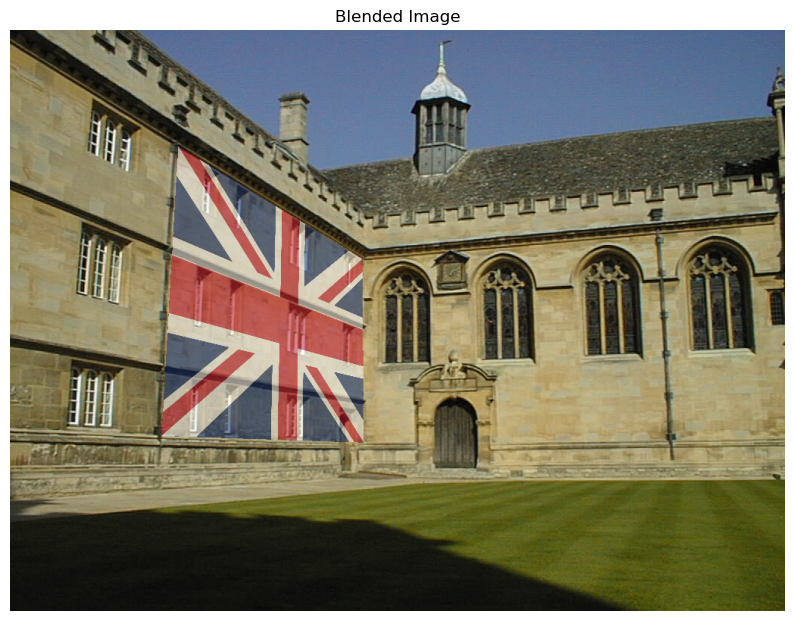

In [51]:
# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Blended Image")
plt.show()